In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import Sampler
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit.library import QFTGate
from qiskit.circuit.library import MCXGate
from qiskit.circuit.library import DraperQFTAdder
from itertools import product
from azure.quantum.qiskit import AzureQuantumProvider

from qiskit.circuit.library import RGQFTMultiplier
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes.synthesis.plugin import (
    HighLevelSynthesisPluginManager,
)
from qiskit.transpiler.passes import HLSConfig
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
import pyzx as zx
import qiskit.qasm2 as qasm2
from qiskit.visualization import circuit_drawer

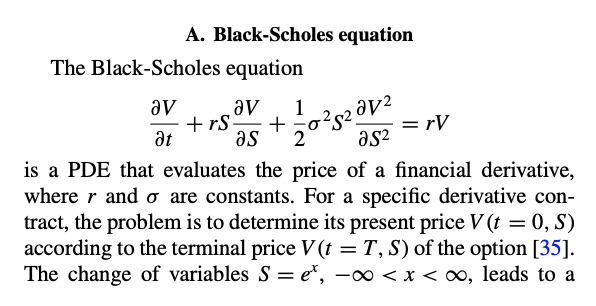
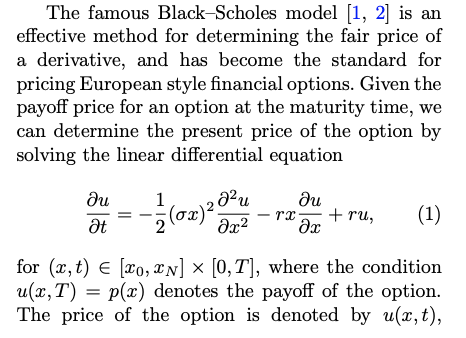

In [2]:

# first define the QFT function

def add_qft(qc, target_qubits, invBool):

    num_qubits = len(target_qubits)
    qft_gate = QFTGate(num_qubits)

    if invBool:  # Apply the inverse if specified
        qft_gateInv = qft_gate.inverse()
        qc.append(qft_gateInv, target_qubits)
    else:
        qc.append(qft_gate, target_qubits)

    return qc


In [3]:

def apply_phase_hamiltonian(qc, r, A, B, sigma2, tau, n):
    """
    Applies the phase e^{iτλ^{(phase)}(q)} to a computational basis state using
    single-, double-, and triple-controlled phase gates.

    N = 2**n
    # ---------- 1) Linear terms on the left: (r~ - σ²/2) A Σ 2^i q_i ----------
    for i in range(0, n+1):
        theta = - (r - sigma2/2.0) * A * (2**i) * tau
        qc.p(theta, i)

    # ---------- 2) Linear terms on the right: r~ B Σ 2^{k-n-1} q_k ----------
    for k in range(n+1, 2*n+1):
        theta = - r * B * (2**(k - n - 1)) * tau
        qc.p(theta, k)

    # ---------- 3) Bilinear left–right: (σ²/2) A² B Σ_i Σ_k 2^{2i+k-n-1} q_i q_k ----------
    for i in range(0, n+1):
        for k in range(n+1, 2*n+1):
            theta = - (sigma2/2.0) * (A**2) * B * (2**(2*i + k - n - 1)) * tau
            qc.cp(theta, i, k)

    # ---------- 4) Trilinear: σ² A² B Σ_{i<j} Σ_k 2^{i+j+k-n-1} q_i q_j q_k ----------
    for i in range(0, n):
        for j in range(i+1, n+1):
            for k in range(n+1, 2*n+1):
                theta = - sigma2 * (A**2) * B * (2**(i + j + k - n - 1)) * tau
                qc.mcp(theta, [i, j], k)

    # ---------- 5) N/2 correction terms from the right factor ----------
    #     + (σ²/2) A² B (N/2) Σ_i 2^{2i} q_i
    for i in range(0, n+1):
        theta = + (sigma2/2.0) * (A**2) * B * (N/2.0) * (2**(2*i)) * tau
        qc.p(theta, i)

    #     + σ² A² B (N/2) Σ_{i<j} 2^{i+j} q_i q_j
    for i in range(0, n):
        for j in range(i+1, n+1):
            theta = + sigma2 * (A**2) * B * (N/2.0) * (2**(i + j)) * tau
            qc.cp(theta, i, j)

In [4]:
def create_circuit(n):
    
    N = 2**n
    M = 2*N    # number of points per spatial dimesnion (assuming square), we make 2*N as in paper for one-dimensional problems (section 2)
    S_max=150
    S_min = 1/S_max
    Lx =  np.log(S_min)
    Rx = np.log(S_max)
    lengthX = Rx-Lx
    deltaX = lengthX/M
    maxWave = np.pi/deltaX

    r = 0.04
    sigma = 0.2 # these parameters are from a paper
    T = 1

    vMax = r + ((sigma**2)*(maxWave**2)/2)

    R0 = 4  # chosen as such that the exponential decays rapidly
    Rp = np.ceil(R0+vMax*T)
    Lp = -R0
    lengthP = Rp-Lp
    deltaP = (Rp-Lp)/N

    # full x-grid: [Lx, Rx]   (symmetric interval in log-space)
    x_grid = np.linspace(Lx, Rx, M, endpoint=True)

    # stock prices corresponding to this x-grid
    S_grid = np.exp(x_grid)

    K = 50

    initial_grid = np.maximum(S_grid - K, 0.0)

    p_values = [(Lp + deltaP * i) for i in range(0,N)]
    p_values = np.array(p_values)
    j_plus = np.ceil(-Lp / deltaP)

    spatialDims = initial_grid.ndim  # need the spatial dimensions to calculate the qubits needed overall (for each dimension)


    fullStack = []

    for i in range(0, len(p_values)):
        p = p_values[i]
        wStack = np.exp(- np.abs(p))*initial_grid
        fullStack.append(wStack)


    wGrid = np.stack(fullStack, axis=-1)
    wFlat = wGrid.flatten(order='C')
    norm = np.linalg.norm(wFlat)
    norm_amps = (1/norm) * wFlat


    # we defined the potential function at the start
    # now we define the diagonal momentum operator matrix (we reduce to a list of diagonal entries)


    numberX = int(np.log2(M))
    numberP = int(np.log2(N))


    num_spatial = numberX * spatialDims
    num_qubits = num_spatial + numberP


    qc = QuantumCircuit(num_qubits, num_qubits)   # add classical if measuring and using sampler

    total_qubits = list(range(0,num_qubits))  # main register with grid values encoded
    qc.initialize(norm_amps, total_qubits)   # prepare the normalised state that encodes the amplitudes across the flattened grid, commented for now

    momQubits = list(range(num_spatial,num_qubits))
    spatQubits = list(range(0,num_spatial))

    allQubits = list(range(0,num_qubits))
    print("Number of qubits: ", num_qubits)

    add_qft(qc, momQubits, True)  
    add_qft(qc, spatQubits, True)
    A = 2*np.pi/lengthX
    B = 2*np.pi/lengthP
    sigma2 = sigma**2
    apply_phase_hamiltonian(qc, r, A, B, sigma2, T, n)


    add_qft(qc, momQubits, False)  
    add_qft(qc, spatQubits, False)

    return qc, num_spatial, numberP, p_values, S_grid

In [5]:
from qiskit.quantum_info import Statevector
import numpy as np

qc, num_spatial, numberP, p_values, S_grid = create_circuit(5)
def recover_u_by_integrating(
    qc,
    num_spatial: int,
    num_p: int,
    p_values: np.ndarray,
    p_register_is_lsb: bool = True
):
    """
    Recovers u(T,x) via u(T,x) = ∫_{0}^{∞} w(T,x,p) dp (Eq. 2).
    Returns: (u_vec, u_state, prob_x, meta)
    """

    # 1) Full state |psi> (encodes w in (x,p) basis up to global normalization)
    psi = Statevector.from_instruction(qc)

    # 2) Put qubits in (x,p) order then reshape -> rows=x, cols=p
    if not p_register_is_lsb:
        psi = psi.reverse_qargs()
    amps = psi.data.reshape((2**num_spatial, 2**num_p))

    # 3) Find first non-negative p index
    j_plus = int(np.argmax(p_values >= 0))

    # 4) Project to p>0, renormalize (projection changes global scale, which we’ll
    #    remove later by normalizing u(T,x) if needed)
    amps_pos = amps.copy()
    amps_pos[:, :j_plus] = 0.0
    flat = amps_pos.ravel()
    norm = np.linalg.norm(flat)
    if norm == 0:
        raise ValueError("Projection onto p>0 produced the zero vector.")
    proj_state = Statevector(flat / norm)

    # 5) Reshape back and integrate w(T,x,p) over p>0 (trapezoidal rule)
    amps_pos = proj_state.data.reshape((2**num_spatial, 2**num_p))
    w_pos = amps_pos[:, j_plus:]                  # shape: (Nx, Np_pos)
    p_pos = p_values[j_plus:]                     # shape: (Np_pos,)
    # u(T,x) ≈ ∫ w dp  → vector over x
    u_vec = np.trapz(w_pos, p_pos, axis=1)

    # 6) Optional normalized |u(T)> state on the x register
    u_norm = np.linalg.norm(u_vec)
    if u_norm == 0:
        raise ValueError("Integrated u_vec is zero; check evolution and p grid.")
    u_state = Statevector(u_vec / u_norm)

    # 7) Classical PDF over x (shape only; integrates to 1)
    prob_x = np.abs(u_vec)**2
    s = prob_x.sum()
    if s != 0:
        prob_x = prob_x / s

    meta = dict(j_plus=j_plus, dp_mean=np.mean(np.diff(p_pos)) if len(p_pos) > 1 else None)
    return u_vec, u_state, prob_x, meta

u_vec, u_state, prob_x, meta = recover_u_by_integrating(
    qc,
    num_spatial,
    numberP,
    p_values,
    True
)

Number of qubits:  11


In [7]:
from qsharp.interop.qiskit import estimate
qc_simple = transpile(
    qc,
    basis_gates=["id", "rz", "sx", "x", "cx"],
    optimization_level=0,   # keep structure; just change basis
)
params = [
    {"name": "qubit_gate_ns_e3", "qubitParams": {"name": "qubit_gate_ns_e3"}},
    {"name": "qubit_gate_ns_e4", "qubitParams": {"name": "qubit_gate_ns_e4"}},
    {"name": "qubit_gate_us_e3", "qubitParams": {"name": "qubit_gate_us_e3"}},
    {"name": "qubit_gate_us_e4", "qubitParams": {"name": "qubit_gate_us_e4"}},
    {"name": "qubit_maj_ns_e4", "qubitParams": {"name": "qubit_maj_ns_e4"}},
    {"name": "qubit_maj_ns_e6", "qubitParams": {"name": "qubit_maj_ns_e6"}},
]

re_result = estimate(qc_simple, params)      # qc is your QuantumCircuit
print(re_result)

# In notebooks/VS Code Jupyter:
from qsharp_widgets import EstimatesOverview
EstimatesOverview(re_result)

{0: {'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'errorCorrectionThreshold': 0.01, 'crossingPrefactor': 0.03, 'logicalCycleTime': '(4 * twoQubitGateTime + 2 * oneQubitMeasurementTime) * codeDistance', 'physicalQubitsPerLogicalQubit': '2 * codeDistance * codeDistance', 'maxCodeDistance': 50}, 'errorBudget': 0.001, 'qubitParams': {'instructionSet': 'GateBased', 'name': 'qubit_gate_ns_e3', 'oneQubitMeasurementTime': '100 ns', 'oneQubitGateTime': '50 ns', 'twoQubitGateTime': '50 ns', 'tGateTime': '50 ns', 'oneQubitMeasurementErrorRate': 0.001, 'oneQubitGateErrorRate': 0.001, 'twoQubitGateErrorRate': 0.001, 'tGateErrorRate': 0.001, 'idleErrorRate': 0.001}, 'constraints': {'maxDistillationRounds': 3}, 'estimateType': 'singlePoint'}, 'physicalCounts': {'physicalQubits': 415074, 'runtime': 654432000, 'rqops': 4852942, 'breakdown': {'algorithmicLogicalQubits': 33, 'algorithmicLogicalDepth': 96240, 'logicalDepth': 96240, 'numTstates': 136488, 'clockFrequency': 147058

EstimatesOverview(estimates={0: {'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'err…


Choose a metric to plot (y-axis):
  1. algorithmic physical qubits
  2. total physical qubits
  3. runtime (ns)
  4. # of T-factory runs
  5. # of parallel T-factories
  6. logical circuit depth
  7. # of T states
  8. rQOPS
Number of qubits:  1
Number of qubits:  3
Number of qubits:  5
Number of qubits:  7
Number of qubits:  9
Number of qubits:  11


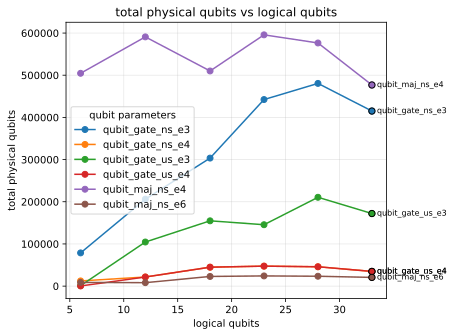

In [9]:
import matplotlib.pyplot as plt

def sweep_and_plot_prompt(create_circuit, ns, params):
    # ----- Ask user which metric to plot -----
    metric_map = {
        "1": ("algo_phys_qubits",  "algorithmic physical qubits"),
        "2": ("total_phys_qubits", "total physical qubits"),
        "3": ("runtime_ns",         "runtime (ns)"),
        "4": ("t_runs",              "# of T-factory runs"),
        "5": ("t_factories",         "# of parallel T-factories"),
        "6": ("logical_depth",       "logical circuit depth"),
        "7": ("t_states",             "# of T states"),
        "8": ("rqops",                "rQOPS"),
    }

    print("\nChoose a metric to plot (y-axis):")
    for k, (_, label) in metric_map.items():
        print(f"  {k}. {label}")

    choice = input("Enter choice number: ").strip()
    if choice not in metric_map:
        print("Invalid choice.")
        return

    y_metric, y_label = metric_map[choice]
    log_choice = input("Use log scale for y-axis? (y/n): ").strip().lower()
    logy = (log_choice == "y")

    def get_metric(entry, key):
        pc = entry["physicalCounts"]
        br = pc["breakdown"]
        return {
            "algo_phys_qubits":   br["physicalQubitsForAlgorithm"],
            "total_phys_qubits":  pc["physicalQubits"],
            "runtime_ns":         pc["runtime"],
            "t_runs":             br["numTfactoryRuns"],
            "t_factories":        br["numTfactories"],
            "logical_depth":      br.get("logicalDepth", br.get("algorithmicLogicalDepth")),
            "t_states":           br.get("numTstates"),
            "rqops":               pc.get("rqops"),
        }[key]

    # ----- Run sweeps -----
    series = {}  # run_name -> [(logical_qubits, yvalue), ...]

    for n in ns:
        qc_raw, num_spatial, numberP, p_values, S_grid = create_circuit(n)
        qc = qc_raw[0] if isinstance(qc_raw, (tuple, list)) else qc_raw

        qc_simple = transpile(qc, basis_gates=["id","rz","sx","x","cx"], optimization_level=0)
        re_result = estimate(qc_simple, params)

        it = re_result.values() if isinstance(re_result, dict) else re_result
        for entry in it:
            name = entry["jobParams"]["qubitParams"]["name"]
            br   = entry["physicalCounts"]["breakdown"]
            x    = br["algorithmicLogicalQubits"]
            y    = get_metric(entry, y_metric)
            series.setdefault(name, []).append((x, y))

    # ----- Plot -----
    plt.figure()
    for name, pts in series.items():
        pts.sort(key=lambda t: t[0])
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        plt.plot(xs, ys, marker="o", label=name)
        plt.scatter(xs[-1], ys[-1], s=40, edgecolors='black', zorder=5)
        plt.text(xs[-1], ys[-1], f"  {name}", fontsize=8, va='center')

    if logy:
        plt.yscale("log")
    plt.xlabel("logical qubits")
    plt.ylabel(y_label)
    plt.title(f"{y_label} vs logical qubits")
    plt.legend(title="qubit parameters")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

sweep_and_plot_prompt(create_circuit, ns=[0,1,2,3,4,5], params=params)

Number of qubits:  1
n=0: declared=1, azure_logical=6
Number of qubits:  3
n=1: declared=3, azure_logical=12
Number of qubits:  5
n=2: declared=5, azure_logical=18
Number of qubits:  7
n=3: declared=7, azure_logical=23
Number of qubits:  9
n=4: declared=9, azure_logical=28
Number of qubits:  11
n=5: declared=11, azure_logical=33


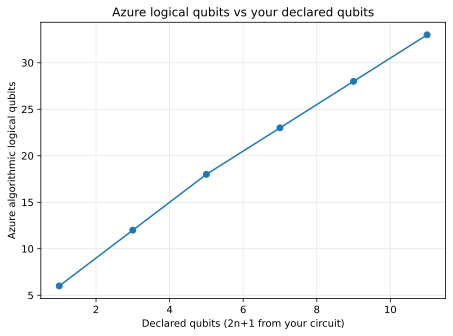

In [11]:
def plot_declared_vs_logical(create_circuit, ns, params):
    declared_counts = []
    logical_counts = []

    for n in ns:
        # Create your circuit
        qc_raw, *_ = create_circuit(n)
        qc = qc_raw[0] if isinstance(qc_raw, (tuple, list)) else qc_raw

        # Your declared number of qubits (2n+1)
        declared = qc.num_qubits
        declared_counts.append(declared)

        # Transpile and send to Azure estimator
        qc_simple = transpile(qc, basis_gates=["id","rz","sx","x","cx"], optimization_level=0)
        re_result = estimate(qc_simple, params)

        # Extract Azure's logical qubit count
        it = re_result.values() if isinstance(re_result, dict) else re_result
        # Just take the first returned configuration (or loop if you want multiple)
        entry = next(iter(it))
        logical = entry["physicalCounts"]["breakdown"]["algorithmicLogicalQubits"]
        logical_counts.append(logical)

        print(f"n={n}: declared={declared}, azure_logical={logical}")

    # Plot
    plt.figure()
    plt.plot(declared_counts, logical_counts, marker="o", color="tab:blue")
    plt.xlabel("Declared qubits (2n+1 from your circuit)")
    plt.ylabel("Azure algorithmic logical qubits")
    plt.title("Azure logical qubits vs your declared qubits")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
plot_declared_vs_logical(create_circuit, ns=[0,1,2,3,4,5], params=params)

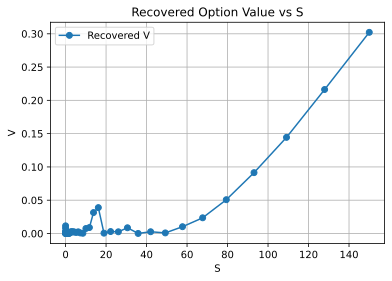

In [6]:
import matplotlib.pyplot as plt

# Assume these exist from earlier in your code:
# S, grids = make_grids(M, S_min, S_max)
# V_vals = np.exp(p_val) * W_vals   # recovered from your quantum output

plt.figure(figsize=(6,4))
plt.plot(S_grid, prob_x, marker='o', label="Recovered V")
plt.xlabel("S")
plt.ylabel("V")
plt.title("Recovered Option Value vs S")
plt.legend()
plt.grid(True)

plt.show()

print(result.quasi_dists[0])

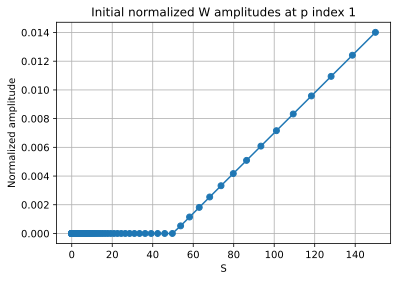

In [11]:
# pick which p index you want to look at
chosen_p_index = 1  # e.g., first momentum value
M = len(S_grid)          # number of spatial points
N = len(p_values)   # number of momentum points

# reshape back to (M, N) from flat array
norm_amps_grid = norm_amps.reshape(M, N, order='C')

# take slice at chosen_p_index
initial_slice = norm_amps_grid[:, chosen_p_index]

# plot S vs this slice
plt.figure(figsize=(6,4))
plt.plot(S_grid, initial_slice, marker='o')
plt.xlabel("S")
plt.ylabel("Normalized amplitude")
plt.title(f"Initial normalized W amplitudes at p index {chosen_p_index}")
plt.grid(True)
plt.show()